### run example_3_preparation.ipynb first

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import collections
import seaborn as sns
import matplotlib
plt.rc('font', size=12)
matplotlib.rcParams['figure.figsize'] = (4,3)

In [10]:
# load data from preparation
pd_fit = pd.read_csv('lowess_fit_from_GCMs_until_2100_RGI13-14-15_2100_OGGM_PyGEM_GloGEM_v2024-03-26.csv', index_col=[0])

quantiles_str = []
quantiles = np.arange(0.01,1,0.01)
for i in quantiles:
    _str = f'q{i:0.2f}' #.format(i)  # Format the percentile string with leading zeros
    quantiles_str.append(_str)
    
# revert the columns 
pd_fit.index = pd_fit.deltaTemp.values.round(2)
pd_fit_v = pd_fit[quantiles_str].T
pd_fit_v['q'] = quantiles

# store pd_fit in an xarray
quantiles = xr.DataArray(pd_fit_v.T.values[:-1], dims=['gmt','q'], coords=dict(gmt=pd_fit_v.columns.values[:-1], q=[float(s[1:]) for s in pd_fit_v.index.values]))

In [11]:
def prob_greater_at_gmt(g, thresh):
    '''
    returns the probability of keeping the threshold amount of glacier at given GMT g
    '''
    y = quantiles.sel(gmt=g, method='nearest')
    return 1 - quantiles.q.values[np.abs(y - thresh).argmin()]

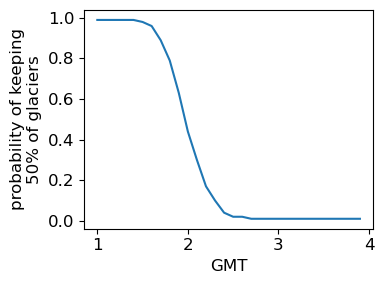

In [12]:
gmt_axis = np.arange(1,4,0.1)
p = np.array([prob_greater_at_gmt(g, 50) for g in gmt_axis])
plt.plot(gmt_axis, p)
plt.xlabel('GMT')
plt.ylabel('probability of keeping\n50% of glaciers')
plt.tight_layout()

GMT:
1986-2005 vs 1850-1900 
1986-2005 should be 0.69K warmer than preindustrial
gmt -= gmt.loc[1986-2005].mean() + 0.69

In [13]:
def prob_greater_in_scenario(scen, thresh):
    '''
    returns the probability of crossing thresh in given scenario
    '''
    # get all gmt values in 2100 from the 2237 runs
    # bin GMT in 0.1 K steps
    # and count occurences in bins
    counter = collections.Counter(gmt.loc[scen].round(1).values)
    p = np.array([])
    # for each bin add the probability of crossing thresh at GMT level "count"-times
    for g,count in counter.items():
        p = np.append(p, [prob_greater_at_gmt(g, thresh)]*count)
    return p.mean()

In [14]:
year = 2100

In [15]:
gmt = xr.open_dataset(f'gmt_in_{year}.nc')['gmt']

In [ ]:
# calculate the probability of keeping X% of the glacier for all 1500 scenarios
p_greater = xr.DataArray(dims=['scenario', 'thresh'], coords=dict(scenario=gmt.scenario.values, thresh=np.arange(40,70,10,'int')))
for thresh in p_greater.thresh.values:
    for scen in p_greater.scenario.values:
        p_greater.loc[scen, thresh] = prob_greater_in_scenario(scen, thresh)
xr.Dataset({'p_greater':p_greater}).to_netcdf(f'p_greater_in_{year}.nc')

In [16]:
p_greater = xr.open_dataset(f'p_greater_in_{year}.nc')['p_greater']

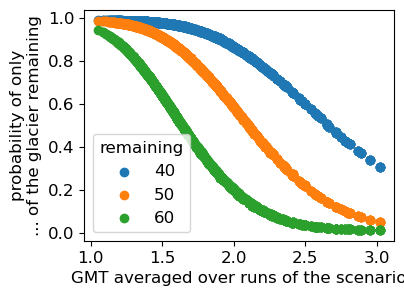

In [17]:
for thresh in p_greater.thresh.values[:]:
    plt.scatter(gmt.mean('run'),p_greater.loc[:,thresh], label=f'{thresh}')
plt.xlabel('GMT averaged over runs of the scenario')
plt.ylabel('probability of only\n... of the glacier remaining')
plt.legend(title='remaining')

In [21]:
# identify scenarios for which there is a 90% chance of keeping 50% of the glaciers
boundary_scenarios = p_greater.scenario[np.abs(p_greater.loc[:,50] - 0.80) < 0.01]

Text(0.5, 0, 'GMST')

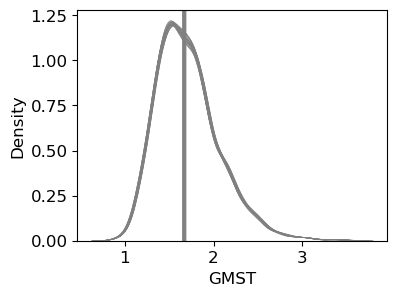

In [22]:
# GMT distributions for boundary scenarios in 2100
fig,ax = plt.subplots(nrows=1, figsize=(4,3))
for scen in boundary_scenarios:
    sns.kdeplot(gmt.loc[scen], color='gray', linewidth=0.3)
    ax.axvline(gmt.loc[scen].median(), color='gray', linewidth=0.3)
ax.set_xlabel('GMST')

In [23]:
# load fair emissions
emissions = pd.read_table('../Tier2_scenarios_emissions.csv', sep=',')
co2 = emissions.loc[(emissions.Variable == 'Emissions|CO2')]
co2 = xr.DataArray(co2.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=co2.Scenario, year=np.array(co2.columns[5:], 'int')))
ch4 = emissions.loc[(emissions.Variable == 'Emissions|CH4')]
ch4 = xr.DataArray(ch4.iloc[:,5:].values, dims=['scen','year'], coords=dict(scen=ch4.Scenario, year=np.array(ch4.columns[5:], 'int')))
cum_co2 = (co2.loc[:,2020:2100].rolling(year=2).sum() * 0.5 * 10).sum('year') / 1000

In [24]:
# select scenarios that stabilize in 2100
# -> no overshoot efore 2100
# -> potential for keeping the glacier mass later on as well
selected_boundary_scenarios = boundary_scenarios[(co2.loc[boundary_scenarios].loc[:,2030] <= co2.loc[boundary_scenarios].loc[:,2020])]

In [25]:
gmt_median = xr.open_dataset('gmt_median.nc')['gmt']

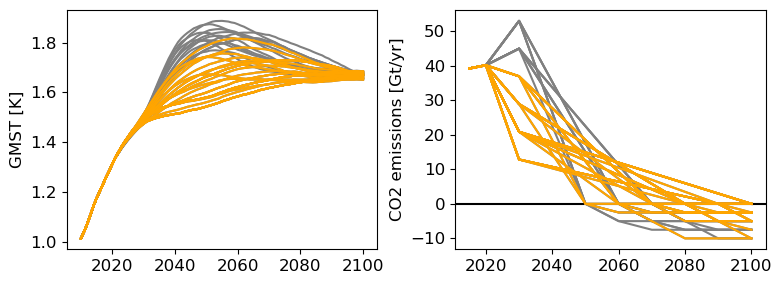

In [26]:

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axes[1].axhline(0, color='k')
for scenarios, color in zip([boundary_scenarios, selected_boundary_scenarios], ['gray','orange']):
    for scen in scenarios.values:
        y = gmt_median.loc[scen,:2100]
        axes[0].plot(y.year, y, label=scen, color=color)
        y = co2.loc[scen,:2100] / 1000
        axes[1].plot(y.year, y, color=color)
    
axes[0].set_ylabel('GMST [K]')
axes[1].set_ylabel('CO2 emissions [Gt/yr]')
plt.tight_layout() 

In [27]:
# get cumulative CO2 emissions until 2100 in the orange scenario
CO2_budget = cum_co2.loc[selected_boundary_scenarios].values.mean()
CO2_budget

848.074668236752